# Telecom churn case study

In [383]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Importing and merging data

In [384]:
churn_data=pd.read_csv('churn_data.csv')
churn_data.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [385]:
customer_data=pd.read_csv('customer_data.csv')
customer_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [386]:
internet_data=pd.read_csv('internet_data.csv')
internet_data.head()

,customerID,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,No,Fiber optic,No,No,No,No,No,No


### Combining data into one

In [387]:
df_1=pd.merge(churn_data,customer_data,how='inner',on='customerID')

In [388]:
#final_dataframe
telecom=pd.merge(df_1,internet_data,how='inner',on='customerID')

In [389]:
print(telecom.shape)
telecom.head()

(7043, 21)


,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Female,...,Yes,No,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,Yes,One year,No,Mailed check,56.95,1889.5,No,Male,...,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,Yes,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Male,...,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Male,...,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,Yes,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Female,...,No,No,No,Fiber optic,No,No,No,No,No,No


In [390]:
telecom.describe()

,tenure,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,0.162147
std,24.559481,30.090047,0.368612
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,0.000000
50%,29.000000,70.350000,0.000000
75%,55.000000,89.850000,0.000000
max,72.000000,118.750000,1.000000


In [391]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
dtypes: float64(1), int64(2), obj

## Data preparation

In [392]:
# dealing with binary variables
varlist=['PhoneService','PaperlessBilling','Churn','Partner','Dependents']

telecom[varlist]=telecom[varlist].apply(lambda x:x.map({'Yes':1,'No':0}))
telecom.head()

,customerID,tenure,PhoneService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,1,0,Month-to-month,1,Electronic check,29.85,29.85,0,Female,...,1,0,No phone service,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,34,1,One year,0,Mailed check,56.95,1889.5,0,Male,...,0,0,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2,1,Month-to-month,1,Mailed check,53.85,108.15,1,Male,...,0,0,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,45,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,Male,...,0,0,No phone service,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2,1,Month-to-month,1,Electronic check,70.70,151.65,1,Female,...,0,0,No,Fiber optic,No,No,No,No,No,No


In [393]:
# Creating dummy variables
dummyList=['Contract','PaymentMethod','gender','InternetService']
dummy1=pd.get_dummies(telecom[dummyList],drop_first=True)
telecom=pd.concat([telecom,dummy1],axis=1)
# dropping the original columns
telecom=telecom.drop(dummyList,1)
telecom

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,...,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic,InternetService_No
0,7590-VHVEG,1,0,1,29.85,29.85,0,0,1,0,...,No,No,0,0,0,1,0,0,0,0
1,5575-GNVDE,34,1,0,56.95,1889.5,0,0,0,0,...,No,No,1,0,0,0,1,1,0,0
2,3668-QPYBK,2,1,1,53.85,108.15,1,0,0,0,...,No,No,0,0,0,0,1,1,0,0
3,7795-CFOCW,45,0,0,42.30,1840.75,0,0,0,0,...,No,No,1,0,0,0,0,1,0,0
4,9237-HQITU,2,1,1,70.70,151.65,1,0,0,0,...,No,No,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,1,1,84.80,1990.5,0,0,1,1,...,Yes,Yes,1,0,0,0,1,1,0,0
7039,2234-XADUH,72,1,1,103.20,7362.9,0,0,1,1,...,Yes,Yes,1,0,1,0,0,0,1,0
7040,4801-JZAZL,11,0,1,29.60,346.45,0,0,1,1,...,No,No,0,0,0,1,0,0,0,0
7041,8361-LTMKD,4,1,1,74.40,306.6,1,1,1,0,...,No,No,0,0,0,0,1,1,1,0


In [394]:
# getting dummy variables for remaining categorical variables

#dummy variables for multiplelines
m1=pd.get_dummies(telecom['MultipleLines'],prefix='MultipleLines',drop_first=True)
telecom=pd.concat([telecom,m1],axis=1)

#dummy variable for OnlineSecurity
m1=pd.get_dummies(telecom['OnlineSecurity'],prefix='OnlineSecurity',drop_first=True)
telecom=pd.concat([telecom,m1],axis=1)

#dummy variable for OnlineBackup
m1=pd.get_dummies(telecom['OnlineBackup'],prefix='OnlineBackup',drop_first=True)
telecom=pd.concat([telecom,m1],axis=1)

#dummy variable for DeviceProtection
m1=pd.get_dummies(telecom['DeviceProtection'],prefix='DeviceProtection',drop_first=True)
telecom=pd.concat([telecom,m1],axis=1)

#dummy variable for TechSupport
m1=pd.get_dummies(telecom['TechSupport'],prefix='TechSupport',drop_first=True)
telecom=pd.concat([telecom,m1],axis=1)

#dummy variable for StreamingTV
m1=pd.get_dummies(telecom['StreamingTV'],prefix='StreamingTV',drop_first=True)
telecom=pd.concat([telecom,m1],axis=1)

#dummy variable for StreamingMovies
m1=pd.get_dummies(telecom['StreamingMovies'],prefix='StreamingMovies',drop_first=True)
telecom=pd.concat([telecom,m1],axis=1)

telecom=telecom.drop(['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies'],axis=1)

telecom

,customerID,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,SeniorCitizen,Partner,Dependents,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,7590-VHVEG,1,0,1,29.85,29.85,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,5575-GNVDE,34,1,0,56.95,1889.5,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3668-QPYBK,2,1,1,53.85,108.15,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,7795-CFOCW,45,0,0,42.30,1840.75,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,2,1,1,70.70,151.65,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,24,1,1,84.80,1990.5,0,0,1,1,...,0,0,0,1,0,1,0,1,0,1
7039,2234-XADUH,72,1,1,103.20,7362.9,0,0,1,1,...,0,1,0,1,0,0,0,1,0,1
7040,4801-JZAZL,11,0,1,29.60,346.45,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
7041,8361-LTMKD,4,1,1,74.40,306.6,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [395]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
customerID                               7043 non-null object
tenure                                   7043 non-null int64
PhoneService                             7043 non-null int64
PaperlessBilling                         7043 non-null int64
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null object
Churn                                    7043 non-null int64
SeniorCitizen                            7043 non-null int64
Partner                                  7043 non-null int64
Dependents                               7043 non-null int64
Contract_One year                        7043 non-null uint8
Contract_Two year                        7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check         

In [396]:
# total charges was imported as string. need to convert it to float
telecom['TotalCharges'] = pd.to_numeric(telecom['TotalCharges'],errors='coerce')

In [397]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 32 columns):
customerID                               7043 non-null object
tenure                                   7043 non-null int64
PhoneService                             7043 non-null int64
PaperlessBilling                         7043 non-null int64
MonthlyCharges                           7043 non-null float64
TotalCharges                             7032 non-null float64
Churn                                    7043 non-null int64
SeniorCitizen                            7043 non-null int64
Partner                                  7043 non-null int64
Dependents                               7043 non-null int64
Contract_One year                        7043 non-null uint8
Contract_Two year                        7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check        

all values were converted to numeric

## checking for outliers

In [398]:
var_list=['tenure','MonthlyCharges','TotalCharges']
telecom[var_list].describe(percentiles=[.25,.5,.75,.9,.95,.99])

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
90%,69.000000,102.600000,5976.640000
95%,72.000000,107.400000,6923.590000
99%,72.000000,114.729000,8039.883000


from the distribution above we can see that there are not outliers in the data

## handling missing values

In [399]:
telecom.isnull().sum()

customerID                                0
tenure                                    0
PhoneService                              0
PaperlessBilling                          0
MonthlyCharges                            0
TotalCharges                             11
Churn                                     0
SeniorCitizen                             0
Partner                                   0
Dependents                                0
Contract_One year                         0
Contract_Two year                         0
PaymentMethod_Credit card (automatic)     0
PaymentMethod_Electronic check            0
PaymentMethod_Mailed check                0
gender_Male                               0
InternetService_Fiber optic               0
InternetService_No                        0
MultipleLines_No phone service            0
MultipleLines_Yes                         0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service

we have few null values in TotalCharges it is best we remove them

In [400]:
telecom=telecom[~np.isnan(telecom['TotalCharges'])]

In [401]:
telecom.isnull().sum()

customerID                               0
tenure                                   0
PhoneService                             0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges                             0
Churn                                    0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
Contract_One year                        0
Contract_Two year                        0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
gender_Male                              0
InternetService_Fiber optic              0
InternetService_No                       0
MultipleLines_No phone service           0
MultipleLines_Yes                        0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBacku

## Train test split

In [402]:
X=telecom.drop(['Churn','customerID'],axis=1)
X.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,1,0,1,29.85,29.85,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,34,1,0,56.95,1889.50,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,2,1,1,53.85,108.15,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,45,0,0,42.30,1840.75,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
4,2,1,1,70.70,151.65,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [403]:
y=telecom.Churn
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [404]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)

## Feature Scaling

In [405]:
X_train.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
879,33,1,1,54.65,1665.20,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5790,40,0,1,50.85,2036.55,0,1,1,0,0,...,0,1,0,0,0,0,0,1,0,1
6498,1,1,1,82.30,82.30,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
880,10,1,1,110.10,1043.30,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
2784,4,1,1,98.10,396.30,0,0,1,0,0,...,0,0,0,1,0,1,0,1,0,1


In [406]:
scaler=StandardScaler()
X_train[['tenure','MonthlyCharges','TotalCharges']]=scaler.fit_transform(X_train[['tenure','MonthlyCharges','TotalCharges']])
X_train.head()

,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,Contract_One year,Contract_Two year,...,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
879,0.019693,1,1,-0.338074,-0.276449,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5790,0.305384,0,1,-0.464443,-0.112702,0,1,1,0,0,...,0,1,0,0,0,0,0,1,0,1
6498,-1.286319,1,1,0.581425,-0.974430,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
880,-0.919003,1,1,1.505913,-0.550676,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,1
2784,-1.163880,1,1,1.106854,-0.835971,0,0,1,0,0,...,0,0,0,1,0,1,0,1,0,1


In [407]:
# checking tyhe churn rate
churn=(sum(telecom['Churn'])*100/len(telecom))
churn

26.57849829351536

we have 27% churn rate

## Looking for corelations

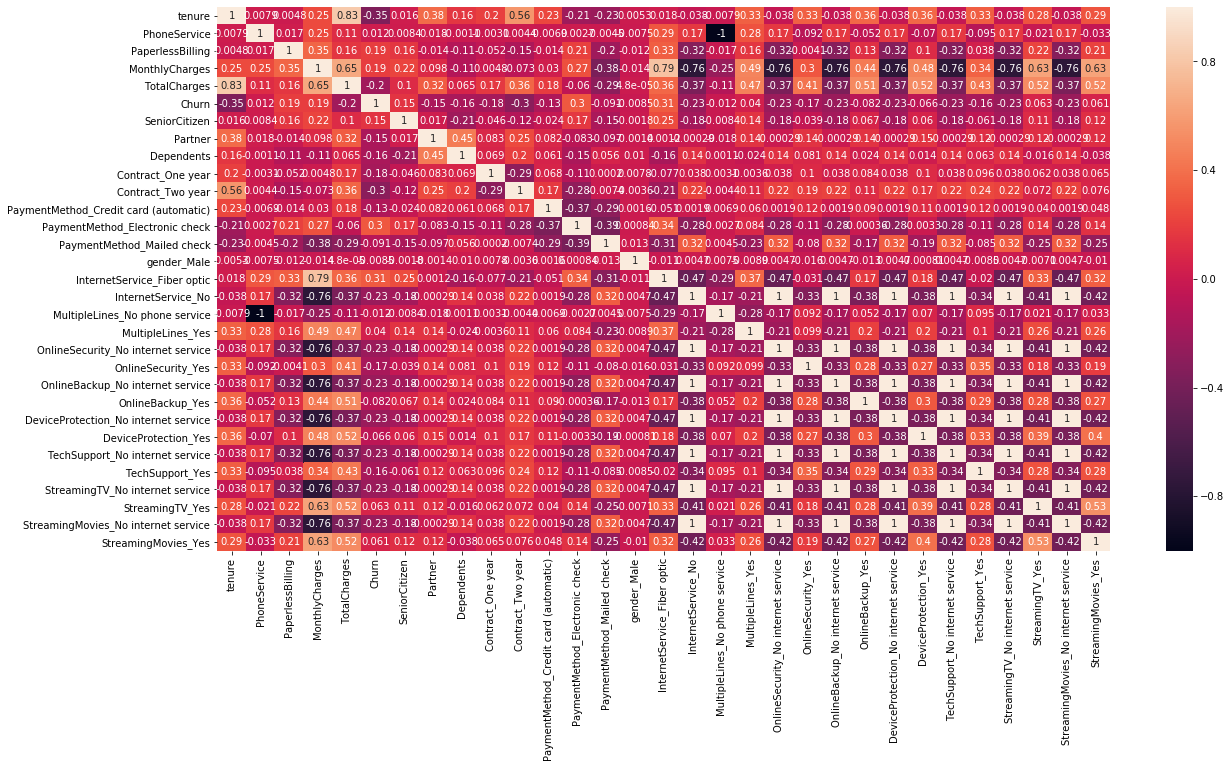

In [408]:
plt.figure(figsize=(20,10))
sns.heatmap(telecom.corr(),annot=True)
plt.show()

In [409]:
X_test.columns

Index(['tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype='object')

In [410]:
# dropping highly correlated variables
X_test=X_test.drop(['OnlineSecurity_No internet service','OnlineBackup_No internet service','DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service','StreamingMovies_No internet service'],1)
X_train=X_train.drop(['OnlineSecurity_No internet service','OnlineBackup_No internet service','DeviceProtection_No internet service','TechSupport_No internet service','StreamingTV_No internet service','StreamingMovies_No internet service'],1)

In [411]:
X_test.columns

Index(['tenure', 'PhoneService', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'SeniorCitizen', 'Partner', 'Dependents',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes'],
      dtype='object')

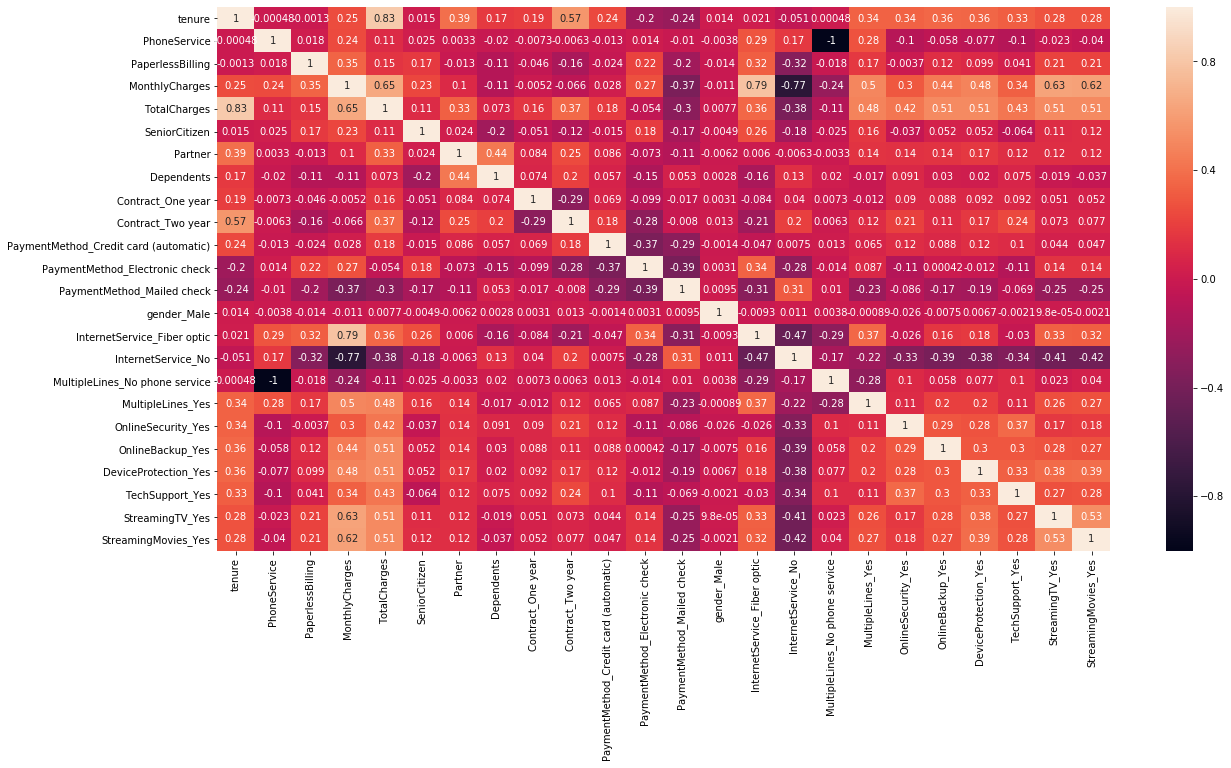

In [412]:
# rechecking correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap(X_train.corr(),annot=True)
plt.show()

## Model Building

In [413]:
logm1=sm.GLM(y_train,(sm.add_constant(X_train)),family=sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4898
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2004.7
Date:                Mon, 09 Aug 2021   Deviance:                       4009.4
Time:                        01:25:10   Pearson chi2:                 6.07e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.3085      0.773     -2.986      0.003      -3.824      -0.793
tenure                                   -1.5172      0.189     -8.015      0.000      -1.888      -1.146
PhoneService                             -0.6789      0.090     -7.510      0.000      -0.856      -0.502
PaperlessBilling                          0.3254      0.090      3.614      0.000       0.149       0.502
MonthlyCharges                           -2.1806      1.160     -1.880      0.060      -4.454       0.092
TotalCharges                              0.7332      0.198      3.705      0.000       0.345       1.121
SeniorCitizen                             0.3984      0.102      3.924      0.000       0.199       0.597
Partner                                   0.0374      0.094      0.399      0.690      -0.146       0.221
Dependents                               -0.1430      0.107     -1.332      0.183      -0.353       0.067
Contract_One year                        -0.6578      0.129     -5.106      0.000      -0.910      -0.405
Contract_Two year                        -1.2455      0.212     -5.874      0.000      -1.661      -0.830
PaymentMethod_Credit card (automatic)    -0.2577      0.137     -1.883      0.060      -0.526       0.011
PaymentMethod_Electronic check            0.1615      0.113      1.434      0.152      -0.059       0.382
PaymentMethod_Mailed check               -0.2536      0.137     -1.845      0.065      -0.523       0.016
gender_Male                              -0.0346      0.078     -0.442      0.658      -0.188       0.119
InternetService_Fiber optic               2.5124      0.967      2.599      0.009       0.618       4.407
InternetService_No                       -2.7792      0.982     -2.831      0.005      -4.703      -0.855
MultipleLines_No phone service           -1.6296      0.776     -2.101      0.036      -3.150      -0.109
MultipleLines_Yes                         0.5623      0.214      2.628      0.009       0.143       0.982
OnlineSecurity_Yes                       -0.0245      0.216     -0.113      0.910      -0.448       0.399
OnlineBackup_Yes                          0.1740      0.212      0.822      0.411      -0.241       0.589
DeviceProtection_Yes                      0.3229      0.215      1.501      0.133      -0.099       0.744
TechSupport_Yes                          -0.0305      0.216     -0.141      0.888      -0.455       0.394
StreamingTV_Yes                           0.9598      0.396      2.423      0.015       0.183       1.736
StreamingMovies_Yes                       0.8484      0.396      2.143      0.032       0.072       1.624
=========================================================================================================
"""

## Feature selection using RFE

In [414]:
logreg=LogisticRegression()
rfe=RFE(logreg,15)
rfe=rfe.fit(X_train,y_train)

In [415]:
rfe.support_

array([ True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True, False,  True,  True, False,  True,
       False, False, False,  True,  True,  True])

In [416]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('tenure', True, 1),
 ('PhoneService', False, 3),
 ('PaperlessBilling', True, 1),
 ('MonthlyCharges', True, 1),
 ('TotalCharges', True, 1),
 ('SeniorCitizen', True, 1),
 ('Partner', False, 8),
 ('Dependents', False, 7),
 ('Contract_One year', True, 1),
 ('Contract_Two year', True, 1),
 ('PaymentMethod_Credit card (automatic)', True, 1),
 ('PaymentMethod_Electronic check', False, 4),
 ('PaymentMethod_Mailed check', True, 1),
 ('gender_Male', False, 9),
 ('InternetService_Fiber optic', True, 1),
 ('InternetService_No', True, 1),
 ('MultipleLines_No phone service', False, 5),
 ('MultipleLines_Yes', True, 1),
 ('OnlineSecurity_Yes', False, 2),
 ('OnlineBackup_Yes', False, 6),
 ('DeviceProtection_Yes', False, 10),
 ('TechSupport_Yes', True, 1),
 ('StreamingTV_Yes', True, 1),
 ('StreamingMovies_Yes', True, 1)]

In [417]:
cols=X_train.columns[rfe.support_]

assesing the model with statsmodels

In [418]:
X_train_sm=sm.add_constant(X_train[cols])
logm2=sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4906
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2011.1
Date:                Mon, 09 Aug 2021   Deviance:                       4022.2
Time:                        01:25:11   Pearson chi2:                 6.25e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -2.2462      0.189    -11.879      0.000      -2.617      -1.876
tenure                                   -1.5596      0.187     -8.334      0.000      -1.926      -1.193
PaperlessBilling                          0.3436      0.090      3.832      0.000       0.168       0.519
MonthlyCharges                           -0.9692      0.199     -4.878      0.000      -1.359      -0.580
TotalCharges                              0.7421      0.197      3.764      0.000       0.356       1.128
SeniorCitizen                             0.4296      0.100      4.312      0.000       0.234       0.625
Contract_One year                        -0.6830      0.128     -5.342      0.000      -0.934      -0.432
Contract_Two year                        -1.2931      0.211     -6.138      0.000      -1.706      -0.880
PaymentMethod_Credit card (automatic)    -0.3724      0.113     -3.308      0.001      -0.593      -0.152
PaymentMethod_Mailed check               -0.3723      0.111     -3.345      0.001      -0.591      -0.154
InternetService_Fiber optic               1.5865      0.216      7.342      0.000       1.163       2.010
InternetService_No                       -1.6897      0.216     -7.830      0.000      -2.113      -1.267
MultipleLines_Yes                         0.3779      0.104      3.640      0.000       0.174       0.581
TechSupport_Yes                          -0.2408      0.109     -2.210      0.027      -0.454      -0.027
StreamingTV_Yes                           0.5796      0.114      5.102      0.000       0.357       0.802
StreamingMovies_Yes                       0.4665      0.111      4.197      0.000       0.249       0.684
=========================================================================================================
"""

In [419]:
y_train_pred=res.predict(X_train_sm)
y_train_pred[:10]

879     0.192642
5790    0.275624
6498    0.599507
880     0.513571
2784    0.648233
3874    0.414846
5387    0.431184
6623    0.801788
4465    0.228194
5364    0.504575
dtype: float64

In [420]:
# creating a dataframe with actual churn flag and the predicted flag
y_train_pred_final=pd.DataFrame({'Churn':y_train.values,'churn_Prob':y_train_pred})
y_train_pred_final['CustId']=y_train.index
y_train_pred_final.head()

,Churn,churn_Prob,CustId
879,0,0.192642,879
5790,0,0.275624,5790
6498,1,0.599507,6498
880,1,0.513571,880
2784,1,0.648233,2784


In [421]:
# creating a new column predicted with value 1 if the churn_Prob>1 else 0
y_train_pred_final['predicted']=y_train_pred_final.churn_Prob.map(lambda x:1 if x>0.5 else 0)
y_train_pred_final.head()

,Churn,churn_Prob,CustId,predicted
879,0,0.192642,879,0
5790,0,0.275624,5790,0
6498,1,0.599507,6498,1
880,1,0.513571,880,1
2784,1,0.648233,2784,1


In [422]:
from sklearn import metrics

#confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Churn,y_train_pred_final.predicted)
print(confusion)

[[3275  360]
 [ 574  713]]


In [423]:
print(metrics.accuracy_score(y_train_pred_final.Churn,y_train_pred_final.predicted))

0.8102397399431126


## Checking VIF

In [424]:
# create a dataframe that contains the name of all feature variables and their respective vif
vif=pd.DataFrame()
vif['Features']=X_train[cols].columns
vif['VIF']=[variance_inflation_factor(X_train[cols].values,i) for i in range(X_train[cols].shape[1])]
vif['VIF']=round(vif['VIF'],2)
vif=vif.sort_values(by='VIF',ascending=False)
vif

,Features,VIF
2,MonthlyCharges,14.85
3,TotalCharges,10.42
0,tenure,7.38
9,InternetService_Fiber optic,5.61
10,InternetService_No,5.27
6,Contract_Two year,3.14
13,StreamingTV_Yes,2.79
14,StreamingMovies_Yes,2.79
1,PaperlessBilling,2.76
11,MultipleLines_Yes,2.38


There are some variables with high VIF. It is better we drop them.

In [425]:
cols=cols.drop('MonthlyCharges')
cols

Index(['tenure', 'PaperlessBilling', 'TotalCharges', 'SeniorCitizen',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Mailed check',
       'InternetService_Fiber optic', 'InternetService_No',
       'MultipleLines_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes'],
      dtype='object')

In [426]:
# lets re-run the model using the selected variables
X_train_sm=sm.add_constant(X_train[cols])
logm3=sm.GLM(y_train,X_train_sm,family=sm.families.Binomial())
res=logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4907
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2023.1
Date:                Mon, 09 Aug 2021   Deviance:                       4046.2
Time:                        01:25:11   Pearson chi2:                 5.80e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.5971      0.130    -12.296      0.000      -1.852      -1.343
tenure                                   -1.3286      0.180     -7.401      0.000      -1.681      -0.977
PaperlessBilling                          0.3533      0.089      3.958      0.000       0.178       0.528
TotalCharges                              0.4347      0.186      2.340      0.019       0.071       0.799
SeniorCitizen                             0.4569      0.099      4.601      0.000       0.262       0.652
Contract_One year                        -0.7289      0.127     -5.729      0.000      -0.978      -0.480
Contract_Two year                        -1.3277      0.210     -6.322      0.000      -1.739      -0.916
PaymentMethod_Credit card (automatic)    -0.3870      0.112     -3.442      0.001      -0.607      -0.167
PaymentMethod_Mailed check               -0.3618      0.110     -3.274      0.001      -0.578      -0.145
InternetService_Fiber optic               0.6888      0.109      6.297      0.000       0.474       0.903
InternetService_No                       -0.9555      0.156     -6.120      0.000      -1.262      -0.649
MultipleLines_Yes                         0.1700      0.094      1.814      0.070      -0.014       0.354
TechSupport_Yes                          -0.4371      0.101     -4.307      0.000      -0.636      -0.238
StreamingTV_Yes                           0.2881      0.096      2.996      0.003       0.100       0.477
StreamingMovies_Yes                       0.1944      0.096      2.031      0.042       0.007       0.382
=========================================================================================================
"""

In [427]:
y_train_pred=res.predict(X_train_sm)
y_train_pred[:10]

879     0.227902
5790    0.228644
6498    0.674892
880     0.615868
2784    0.662260
3874    0.418199
5387    0.288133
6623    0.795137
4465    0.174332
5364    0.519088
dtype: float64

In [428]:
y_train_pred_final['churn_Prob']=y_train_pred
# creating predicted
y_train_pred_final['predicted'] = y_train_pred_final.churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,churn_Prob,CustId,predicted
879,0,0.227902,879,0
5790,0,0.228644,5790,0
6498,1,0.674892,6498,1
880,1,0.615868,880,1
2784,1,0.662260,2784,1


In [429]:
y_train_pred_final

,Churn,churn_Prob,CustId,predicted
879,0,0.227902,879,0
5790,0,0.228644,5790,0
6498,1,0.674892,6498,1
880,1,0.615868,880,1
2784,1,0.662260,2784,1
...,...,...,...,...
79,0,0.017493,79,0
3934,0,0.094122,3934,0
5964,0,0.057996,5964,0
6947,0,0.110657,6947,0


In [430]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8057700121901666


So overall the accuracy hasn't dropped much.

### Let's check the VIFs again

In [431]:
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,TotalCharges,7.46
0,tenure,6.90
5,Contract_Two year,3.07
8,InternetService_Fiber optic,2.96
13,StreamingMovies_Yes,2.62
12,StreamingTV_Yes,2.59
1,PaperlessBilling,2.55
9,InternetService_No,2.44
10,MultipleLines_Yes,2.27
11,TechSupport_Yes,1.95


In [432]:
# Let's drop TotalCharges since it has a high VIF
cols = cols.drop('TotalCharges')
cols

Index(['tenure', 'PaperlessBilling', 'SeniorCitizen', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Mailed check', 'InternetService_Fiber optic',
       'InternetService_No', 'MultipleLines_Yes', 'TechSupport_Yes',
       'StreamingTV_Yes', 'StreamingMovies_Yes'],
      dtype='object')

In [433]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[cols])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 4922
Model:                            GLM   Df Residuals:                     4908
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2025.9
Date:                Mon, 09 Aug 2021   Deviance:                       4051.9
Time:                        01:25:11   Pearson chi2:                 5.25e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -1.6577      0.127    -13.094      0.000      -1.906      -1.410
tenure                                   -0.9426      0.065    -14.480      0.000      -1.070      -0.815
PaperlessBilling                          0.3455      0.089      3.877      0.000       0.171       0.520
SeniorCitizen                             0.4597      0.100      4.613      0.000       0.264       0.655
Contract_One year                        -0.7218      0.127     -5.702      0.000      -0.970      -0.474
Contract_Two year                        -1.2987      0.208     -6.237      0.000      -1.707      -0.891
PaymentMethod_Credit card (automatic)    -0.3874      0.113     -3.442      0.001      -0.608      -0.167
PaymentMethod_Mailed check               -0.3307      0.110     -3.020      0.003      -0.545      -0.116
InternetService_Fiber optic               0.8052      0.097      8.272      0.000       0.614       0.996
InternetService_No                       -0.9726      0.155     -6.261      0.000      -1.277      -0.668
MultipleLines_Yes                         0.2097      0.092      2.279      0.023       0.029       0.390
TechSupport_Yes                          -0.4046      0.101     -4.019      0.000      -0.602      -0.207
StreamingTV_Yes                           0.3390      0.094      3.619      0.000       0.155       0.523
StreamingMovies_Yes                       0.2428      0.093      2.598      0.009       0.060       0.426
=========================================================================================================
"""

In [434]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

879     0.245817
5790    0.265361
6498    0.669410
880     0.630970
2784    0.682916
3874    0.399526
5387    0.275828
6623    0.798168
4465    0.198786
5364    0.529119
dtype: float64

In [435]:
y_train_pred_final['churn_Prob'] = y_train_pred
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Churn,churn_Prob,CustId,predicted
879,0,0.245817,879,0
5790,0,0.265361,5790,0
6498,1,0.669410,6498,1
880,1,0.630970,880,1
2784,1,0.682916,2784,1


In [436]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.8061763510767981


So overall the accuracy hasn't dropped much.

### Let's check the VIFs again

In [437]:
vif = pd.DataFrame()
vif['Features'] = X_train[cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols].values, i) for i in range(X_train[cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,Contract_Two year,2.98
7,InternetService_Fiber optic,2.67
12,StreamingMovies_Yes,2.54
11,StreamingTV_Yes,2.51
1,PaperlessBilling,2.45
9,MultipleLines_Yes,2.24
0,tenure,2.04
8,InternetService_No,2.03
10,TechSupport_Yes,1.92
3,Contract_One year,1.78


All variables have a good vif and we need not drop any more features

In [438]:
# rechecking the confusion matrix
confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
confusion

array([[3278,  357],
       [ 597,  690]], dtype=int64)

### checking other metrics

In [439]:
TP=confusion[1,1]
TN=confusion[0,0]
FN=confusion[0,1]
FP=confusion[1,0]

In [440]:
sensitivity=TP/float(TP+FN)
sensitivity

0.6590257879656161

In [441]:
specificity=TN/float(TN+FP)
specificity

0.8459354838709677

In [442]:
#false positivity rate
print(FP/float(FP+TN))

0.15406451612903227


## Plotting an ROC curve

In [443]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [444]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.churn_Prob, drop_intermediate = False )

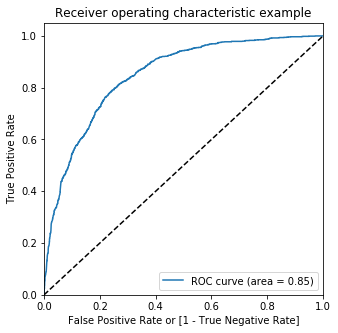

In [445]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.churn_Prob)

## Finding optimal cut-off point

In [446]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,churn_Prob,CustId,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
879,0,0.245817,879,0,1,1,1,0,0,0,0,0,0,0
5790,0,0.265361,5790,0,1,1,1,0,0,0,0,0,0,0
6498,1,0.669410,6498,1,1,1,1,1,1,1,1,0,0,0
880,1,0.630970,880,1,1,1,1,1,1,1,1,0,0,0
2784,1,0.682916,2784,1,1,1,1,1,1,1,1,0,0,0


In [447]:
# calculating accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.261479  1.000000  0.000000
0.1   0.1  0.614994  0.943279  0.498762
0.2   0.2  0.721861  0.846154  0.677854
0.3   0.3  0.770012  0.776224  0.767813
0.4   0.4  0.790532  0.636364  0.845117
0.5   0.5  0.806176  0.536131  0.901788
0.6   0.6  0.798050  0.380730  0.945805
0.7   0.7  0.776310  0.196581  0.981568
0.8   0.8  0.747867  0.041181  0.998074
0.9   0.9  0.738521  0.000000  1.000000


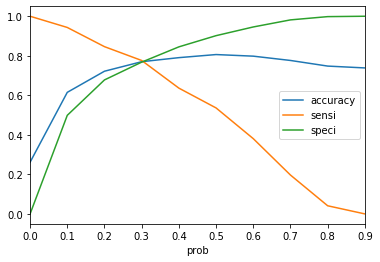

In [448]:
#ploting accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

from the above we can see that 0.3 is the optimum value

In [449]:
y_train_pred_final['final_predicted'] = y_train_pred_final.churn_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Churn,churn_Prob,CustId,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
879,0,0.245817,879,0,1,1,1,0,0,0,0,0,0,0,0
5790,0,0.265361,5790,0,1,1,1,0,0,0,0,0,0,0,0
6498,1,0.669410,6498,1,1,1,1,1,1,1,1,0,0,0,1
880,1,0.630970,880,1,1,1,1,1,1,1,1,0,0,0,1
2784,1,0.682916,2784,1,1,1,1,1,1,1,1,0,0,0,1


In [450]:
#accuracy
metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.final_predicted)

0.7700121901665989

In [451]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.final_predicted )
confusion2

array([[2791,  844],
       [ 288,  999]], dtype=int64)

## Precision and recall

In [452]:
# precision = TP/TP+FP
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.6590257879656161

In [453]:
# recall= TP/TP+FN
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.5361305361305362

## precison and recall trade off

In [454]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds=precision_recall_curve(y_train_pred_final.Churn,y_train_pred_final.churn_Prob)

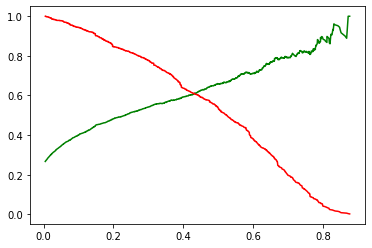

In [455]:
plt.plot(thresholds,p[:-1],"g-")
plt.plot(thresholds,r[:-1],"r-")
plt.show()

## Making predictions on test set

In [456]:
X_test[['tenure','MonthlyCharges','TotalCharges']] = scaler.transform(X_test[['tenure','MonthlyCharges','TotalCharges']])

In [457]:
X_test=X_test[cols]
X_test.head()

,tenure,PaperlessBilling,SeniorCitizen,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,MultipleLines_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes
942,-0.347623,1,0,0,0,1,0,1,0,0,0,0,1
3730,0.999203,1,0,0,0,1,0,1,0,1,0,1,1
1761,1.040015,1,0,0,1,1,0,0,1,1,0,0,0
2283,-1.286319,1,0,0,0,0,1,1,0,0,0,0,0
1872,0.346196,0,0,0,1,0,0,0,1,0,0,0,0


In [458]:
X_test_sm=sm.add_constant(X_test)

In [460]:
# making predictions on test set
y_test_pred=res.predict(X_test_sm)
y_test_pred[:10]

942     0.419725
3730    0.260232
1761    0.008650
2283    0.592626
1872    0.013989
1970    0.692893
2532    0.285289
1616    0.008994
2485    0.602307
5914    0.145153
dtype: float64

In [462]:
y_pred_1=pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
942,0.419725
3730,0.260232
1761,0.008650
2283,0.592626
1872,0.013989


In [463]:
# converting _test to dataframe
y_test_df=pd.DataFrame(y_test)

In [465]:
# putting CustID to index
y_test_df['CustID']=y_test_df.index

In [466]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [468]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

,Churn,CustID,0
0,0,942,0.419725
1,1,3730,0.260232
2,0,1761,0.008650
3,1,2283,0.592626
4,0,1872,0.013989


In [470]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Churn_Prob'})
# Rearranging the columns
y_pred_final.head()

,Churn,CustID,Churn_Prob
0,0,942,0.419725
1,1,3730,0.260232
2,0,1761,0.008650
3,1,2283,0.592626
4,0,1872,0.013989


In [471]:
y_pred_final['final_predicted'] = y_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.42 else 0)
y_pred_final.head()

,Churn,CustID,Churn_Prob,final_predicted
0,0,942,0.419725,0
1,1,3730,0.260232,0
2,0,1761,0.008650,0
3,1,2283,0.592626,1
4,0,1872,0.013989,0


In [472]:
#accuracy
metrics.accuracy_score(y_pred_final.Churn, y_pred_final.final_predicted)

0.7838862559241706

In [473]:
confusion2 = metrics.confusion_matrix(y_pred_final.Churn, y_pred_final.final_predicted )
confusion2

array([[1286,  242],
       [ 214,  368]], dtype=int64)

In [474]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [475]:
#sensitivity
TP / float(TP+FN)

0.6323024054982818

In [476]:
# specificity
TN / float(TN+FP)

0.8416230366492147